In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/preprocessed_data/Player_Season_Summary_with_Appearances.csv")

In [ ]:
features = [
    'overall_rating', 'potential',
    'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
    'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control',
    'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
    'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
    'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
    'marking', 'standing_tackle', 'sliding_tackle', 'num_appearances'
]

In [4]:
import numpy as np
from scipy.stats import wilcoxon

# --- (1) By fetching given data for the different models down below, load the season-wise RMSE for each model) ---

rmse_hurdle = np.array([1.312677, 1.415263, 1.398030, 1.265641, 1.255034, 1.550097, 1.391492])

# rmse_baseline = np.array([1.305985, 1.292830, 1.351061, 1.275696, 1.250296, 1.566565, 1.086344]) #LightGBM
rmse_lgbm = [1.305985, 1.292830, 1.351061, 1.275696, 1.250296, 1.566565, 1.086344]
rmse_rf = [1.316334, 1.301402, 1.332636, 1.265565, 1.265718, 1.568929, 1.073752]
rmse_glm = [1.569358, 1.464470, 1.589228, 1.409680, 1.434545, 1.688907, 1.199120]


# --- (2) Wilcoxon signed-rank test ---
stat, p_value = wilcoxon(rmse_hurdle, rmse_lgbm)
print(f"Wilcoxon signed-rank test statistic for LightGBM = {stat:.2f}, p-value = {p_value:.3f}")


stat, p_value = wilcoxon(rmse_hurdle, rmse_rf)
print(f"Wilcoxon signed-rank test statistic for Random Forest = {stat:.2f}, p-value = {p_value:.3f}")

stat, p_value = wilcoxon(rmse_hurdle, rmse_glm)
print(f"Wilcoxon signed-rank test statistic for GLM = {stat:.2f}, p-value = {p_value:.3f}")




Wilcoxon signed-rank test statistic for LightGBM = 7.00, p-value = 0.297
Wilcoxon signed-rank test statistic for Random Forest = 9.00, p-value = 0.469
Wilcoxon signed-rank test statistic for GLM = 6.00, p-value = 0.219


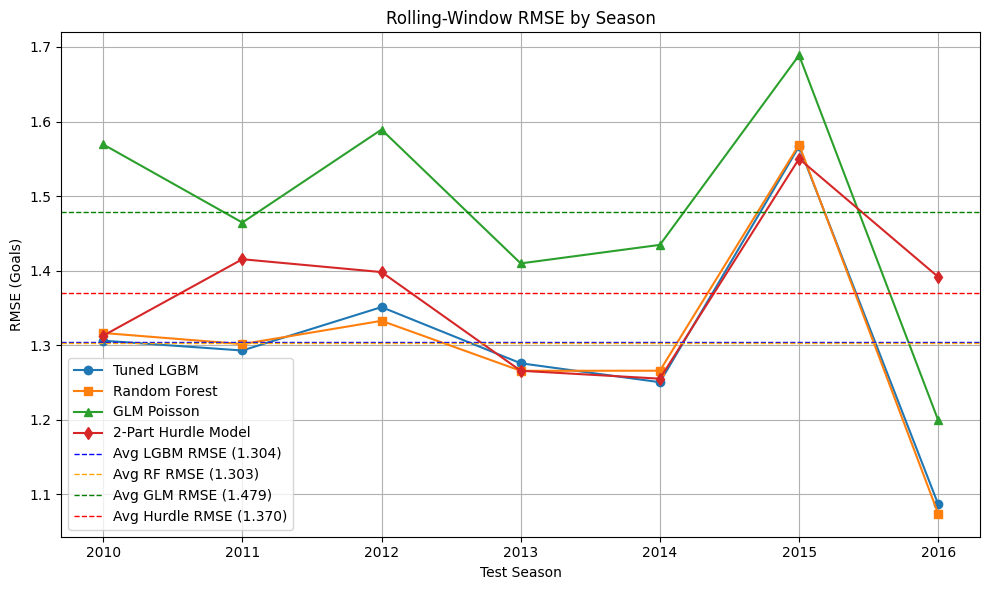

In [2]:
import matplotlib.pyplot as plt

# Here we plot a comparison graph for all the different models

seasons = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
rmse_lgbm = [1.305985, 1.292830, 1.351061, 1.275696, 1.250296, 1.566565, 1.086344]
rmse_rf = [1.316334, 1.301402, 1.332636, 1.265565, 1.265718, 1.568929, 1.073752]
rmse_glm = [1.569358, 1.464470, 1.589228, 1.409680, 1.434545, 1.688907, 1.199120]
rmse_hurdle = [1.312677, 1.415263, 1.398030, 1.265641, 1.255034, 1.550097, 1.391492]

# Plot
plt.figure(figsize=(10,6))
plt.plot(seasons, rmse_lgbm, marker='o', label="Tuned LGBM")
plt.plot(seasons, rmse_rf, marker='s', label="Random Forest")
plt.plot(seasons, rmse_glm, marker='^', label="GLM Poisson")
plt.plot(seasons, rmse_hurdle, marker='d', label="2-Part Hurdle Model")

# Average lines
plt.axhline(y=1.304, color='blue', linestyle='--', linewidth=1, label="Avg LGBM RMSE (1.304)")
plt.axhline(y=1.303, color='orange', linestyle='--', linewidth=1, label="Avg RF RMSE (1.303)")
plt.axhline(y=1.479, color='green', linestyle='--', linewidth=1, label="Avg GLM RMSE (1.479)")
plt.axhline(y=1.370, color='red', linestyle='--', linewidth=1, label="Avg Hurdle RMSE (1.370)")

plt.title("Rolling-Window RMSE by Season")
plt.xlabel("Test Season")
plt.ylabel("RMSE (Goals)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:



missing = [c for c in features if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# ---  Prepare seasons list ---
seasons = sorted(df['season'].unique())
min_train_seasons = 3  # start testing once we have at least 3 seasons to train on


Rolling-Window Backtest Results:
 train_upto  test_season  rmse_rf  rmse_glm
       2009         2010 1.316334  1.569358
       2010         2011 1.301402  1.464470
       2011         2012 1.332636  1.589228
       2012         2013 1.265565  1.409680
       2013         2014 1.265718  1.434545
       2014         2015 1.568929  1.688907
       2015         2016 1.073752  1.199120

Average backtest RMSE (Random Forest): 1.303
Average backtest RMSE (GLM Poisson): 1.479


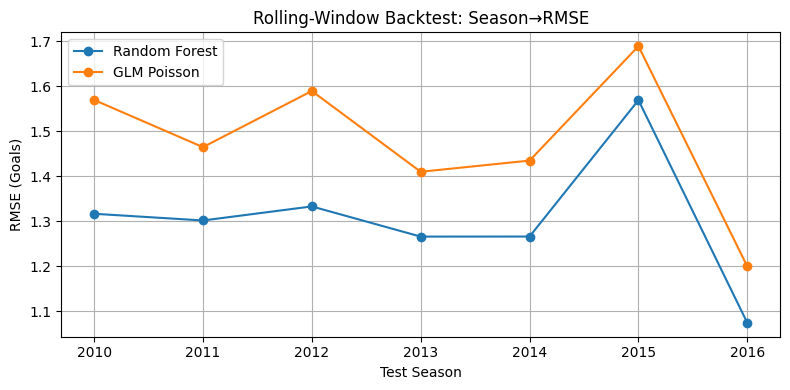

In [ ]:
# Container for backtest results
results = []

# ---  Rolling‐window backtest ---
for i in range(min_train_seasons, len(seasons)):
    train_seasons = seasons[:i]
    test_season   = seasons[i]

    train_df = df[df['season'].isin(train_seasons)]
    test_df  = df[df['season'] == test_season]

    X_train = train_df[features]
    y_train = train_df['total_goals']
    X_test  = test_df[features]
    y_test  = test_df['total_goals']

    # Fit a simple Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Predict & score Random Forest
    y_pred_rf = rf_model.predict(X_test)
    rmse_rf   = np.sqrt(mean_squared_error(y_test, y_pred_rf))

    # Fit GLM Poisson baseline
    glm_poisson = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Poisson())
    res_glm = glm_poisson.fit()

    # Predict & score GLM Poisson
    y_pred_glm = res_glm.predict(sm.add_constant(X_test))
    rmse_glm   = np.sqrt(mean_squared_error(y_test, y_pred_glm))


    results.append({
        'train_upto': train_seasons[-1],
        'test_season': test_season,
        'rmse_rf': rmse_rf,
        'rmse_glm': rmse_glm
    })

# ---  Collect & display results ---
backtest_df = pd.DataFrame(results)
print("Rolling-Window Backtest Results:")
print(backtest_df.to_string(index=False))

avg_rmse_rf = backtest_df['rmse_rf'].mean()
avg_rmse_glm = backtest_df['rmse_glm'].mean()
print(f"\nAverage backtest RMSE (Random Forest): {avg_rmse_rf:.3f}")
print(f"Average backtest RMSE (GLM Poisson): {avg_rmse_glm:.3f}")

# ---  Plot the RMSE over test seasons ---
plt.figure(figsize=(8,4))
plt.plot(
    backtest_df['test_season'],
    backtest_df['rmse_rf'],
    marker='o', linestyle='-', label='Random Forest'
)
plt.plot(
    backtest_df['test_season'],
    backtest_df['rmse_glm'],
    marker='o', linestyle='-', label='GLM Poisson'
)
plt.title("Rolling‐Window Backtest: Season→RMSE")
plt.xlabel("Test Season")
plt.ylabel("RMSE (Goals)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

       player_api_id        season  overall_rating     potential  \
count   62860.000000  62860.000000    62860.000000  62860.000000   
mean   120680.118836   2011.356904        0.474308      0.484458   
std    117256.387373      2.881685        0.169356      0.167475   
min      2625.000000   2007.000000        0.000000      0.000000   
25%     33941.000000   2009.000000        0.365854      0.358974   
50%     69553.000000   2011.000000        0.471545      0.487179   
75%    179791.000000   2014.000000        0.585366      0.598291   
max    546034.000000   2016.000000        1.000000      1.000000   

           crossing     finishing  heading_accuracy  short_passing  \
count  62860.000000  62860.000000      62860.000000   62860.000000   
mean       0.578679      0.499918          0.575800       0.567788   
std        0.155397      0.188645          0.141396       0.139741   
min        0.021978      0.000000          0.000000       0.000000   
25%        0.479853      0.347826    

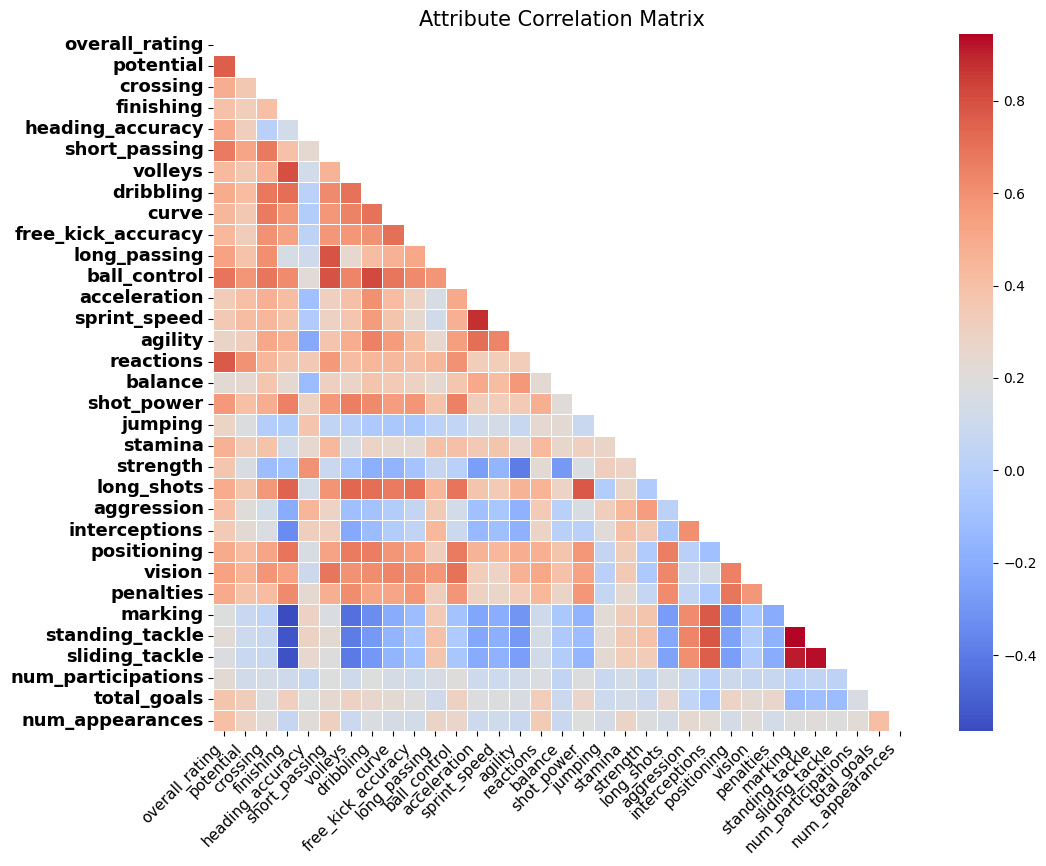

Percentage of player-seasons with zero goals: 82.5%


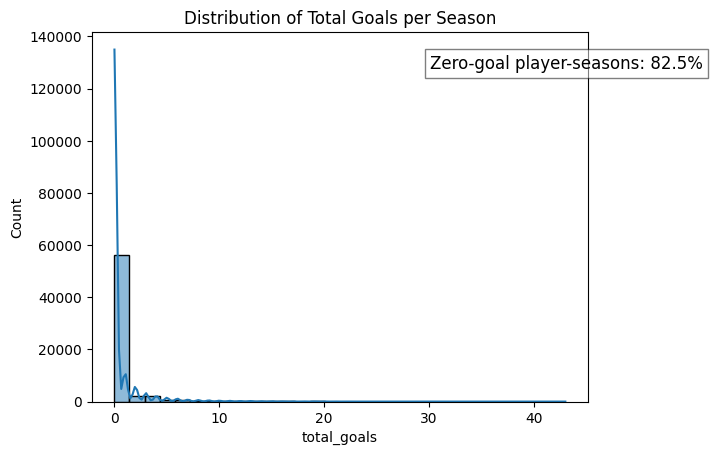

In [ ]:
print(df.describe())


print("\nDescriptive statistics for player-seasons with goals > 0:")
print(df[df['total_goals'] > 0].describe())

# Correlation heatmap
corr = df.drop(['player_api_id','season'], axis=1).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    fmt=".2f",
    linewidths=.5,
    cbar=True,
    xticklabels=True,
    yticklabels=True,
    square=True
)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=13, fontweight='bold')
plt.title("Attribute Correlation Matrix", fontsize=15)
plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.savefig("corr_heatmap_masked.pdf")
plt.show()


zero_goals_count = (df['total_goals'] == 0).sum()
total_player_seasons = len(df)
percent_zero_goals = 100 * zero_goals_count / total_player_seasons

print(f"Percentage of player-seasons with zero goals: {percent_zero_goals:.1f}%")

# Goals distribution
sns.histplot(df['total_goals'], bins=30, kde=True)
plt.title("Distribution of Total Goals per Season")
plt.text(
    x=max(df['total_goals']) * 0.7,
    y=plt.ylim()[1] * 0.9,
    s=f"Zero-goal player-seasons: {percent_zero_goals:.1f}%",
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)
plt.show()


In [ ]:
scored_df = df[df['total_goals'] > 0]
print(scored_df['total_goals'].describe())

count    11017.000000
mean         3.342198
std          3.695592
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         43.000000
Name: total_goals, dtype: float64


In [ ]:
# Correlation matrix for selected features
selected_cols = ['finishing', 'overall_rating', 'num_appearances', 'total_goals']
corr = df[selected_cols].corr()

print(corr)

# For specific pairs
print("Finishing vs Overall Rating:", corr.loc['finishing', 'overall_rating'])
print("Appearances vs Goals:", corr.loc['num_appearances', 'total_goals'])

                 finishing  overall_rating  num_appearances  total_goals
finishing         1.000000        0.393393         0.070835     0.307854
overall_rating    0.393393        1.000000         0.406061     0.373226
num_appearances   0.070835        0.406061         1.000000     0.408915
total_goals       0.307854        0.373226         0.408915     1.000000
Finishing vs Overall Rating: 0.39339337573894184
Appearances vs Goals: 0.40891466775686114


In [ ]:
# Regression target already `total_goals`
# Classification: high‐scorer = top 25% of goal counts
threshold = df['total_goals'].quantile(0.75)
df['high_scorer'] = (df['total_goals'] >= threshold).astype(int)


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np

# 1) Split by season
train = df[df['season'] <= 2014].copy()
test  = df[df['season']  >  2014].copy()


In [ ]:

# 2) Create regression target (unchanged)
y_reg_train = train['total_goals']
y_reg_test  = test ['total_goals']

In [ ]:
# 3) New classification target: scored at least one goal
train['scored_any'] = (train['total_goals'] > 0).astype(int)
test ['scored_any'] = (test ['total_goals'] > 0).astype(int)

y_clf_train = train['scored_any']
y_clf_test  = test ['scored_any']

In [ ]:
# 4) Feature matrices
drop_cols = ['player_api_id','season','total_goals','high_scorer','scored_any']
X_train = train.drop(columns=drop_cols, errors='ignore')
X_test  = test .drop(columns=drop_cols, errors='ignore')

In [ ]:
# --- Regression ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_reg_train)
y_pred = rf.predict(X_test)
print("Regressor RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_pred)))
print("Regressor R²:",   r2_score(y_reg_test, y_pred))

Regressor RMSE: 1.3795924671379487
Regressor R²: 0.6010737392594914


In [ ]:
# --- Classification ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_clf_train)
y_hat = clf.predict(X_test)

In [ ]:
# Now predict_proba will have two columns [P(0), P(1)]
probs = clf.predict_proba(X_test)[:, 1]

print("Classifier Accuracy:", accuracy_score(y_clf_test, y_hat))
print("Precision:",           precision_score(y_clf_test, y_hat))
print("Recall:",              recall_score(y_clf_test, y_hat))
print("ROC AUC:",             roc_auc_score(y_clf_test, probs))

Classifier Accuracy: 0.8462794918330309
Precision: 0.7390625
Recall: 0.5432618683001531
ROC AUC: 0.8945655881950101


In [ ]:
import statsmodels.api as sm
glm_poisson = sm.GLM(y_reg_train, sm.add_constant(X_train), family=sm.families.Poisson())
res = glm_poisson.fit()
print(res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_goals   No. Observations:                51840
Model:                            GLM   Df Residuals:                    51807
Model Family:                 Poisson   Df Model:                           32
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33639.
Date:                Wed, 23 Apr 2025   Deviance:                       44123.
Time:                        20:12:18   Pearson chi2:                 6.45e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.7984
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.5783      0

In [ ]:
param_dist = {
    # tree complexity
    'num_leaves':        [31, 50, 70, 100, 150],
    'max_depth':         [5, 8, 12, 16, -1],   # -1 = no limit
    # regularization
    'reg_alpha':         [0.0, 0.1, 0.5, 1.0],
    'reg_lambda':        [0.0, 0.1, 0.5, 1.0],
    # data subsampling
    'subsample':         [0.6, 0.8, 1.0],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'min_child_samples': [5, 10, 20, 50],
    # learning rate (we’ll keep n_estimators high so we can early‑stop)
    'learning_rate':     [0.005, 0.01, 0.02, 0.05]
}


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import lightgbm as lgb

tscv = TimeSeriesSplit(n_splits=5)

rs = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(objective='poisson', n_estimators=2000, random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
fit_params = {
    'eval_set': [(X_train,y_reg_train),(X_test,y_reg_test)],
    'eval_metric': 'l2',
    'callbacks': [lgb.early_stopping(50)]
}
rs.fit(X_train, y_reg_train, **fit_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1188]	training's l2: 1.0685	training's poisson: -0.0512205	valid_1's l2: 1.88872	valid_1's poisson: 0.049361


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(n_estimators=2000,
                                           objective='poisson',
                                           random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.005, 0.01, 0.02,
                                                          0.05],
                                        'max_depth': [5, 8, 12, 16, -1],
                                        'min_child_samples': [5, 10, 20, 50],
                                        'num_leaves': [31, 50, 70, 100, 150],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [ ]:
best_params = {'learning_rate':0.01, 'max_depth':5, 'min_child_samples':50,
              'n_estimators':2000, 'num_leaves':150, 'objective':'poisson',
              'random_state':42, 'reg_alpha':0.1, 'reg_lambda':0.5, 'subsample':0.8}

Tuned params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 150, 'min_child_samples': 50, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1095]	valid_0's l2: 1.7056	valid_0's poisson: -0.0152463
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1081]	valid_0's l2: 1.67141	valid_0's poisson: -0.0377991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1008]	valid_0's l2: 1.82537	valid_0's poisson: -0.0311865
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 1.6274	valid_0's poisson: -0.0782511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1609]	valid_0's l2: 1.56324	valid_0's poisson: -0.0247467
Training until validation scores don

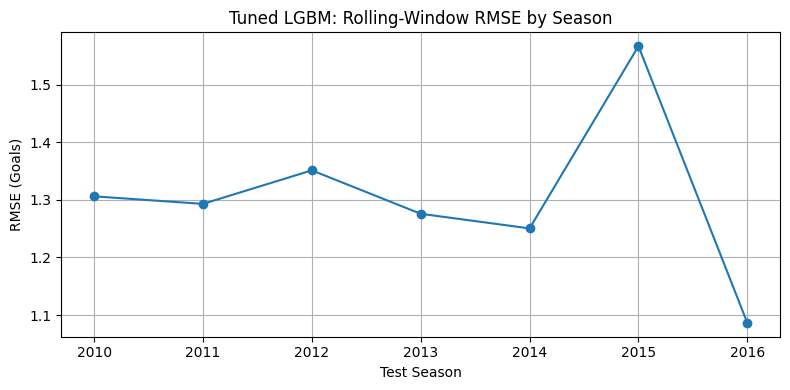

In [ ]:
best_params = rs.best_params_
print("Tuned params:", best_params)
# I can also hard‐code best_params after the first attempt:
# best_params = {'num_leaves':50, 'max_depth':5, … }

# ---  Rolling‐window backtest with tuned LGBM ---
results = []
min_train = 3

for i in range(min_train, len(seasons)):
    train_seasons = seasons[:i]
    test_season   = seasons[i]

    train_df = df[df['season'].isin(train_seasons)]
    test_df  = df[df['season']==test_season]

    X_tr, y_tr = train_df[features], train_df['total_goals']
    X_te, y_te = test_df[features] , test_df['total_goals']


    model = lgb.LGBMRegressor(
        objective='poisson',
        n_estimators=2000,
        random_state=42,
        verbose=-1,
        **best_params
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_te,y_te)],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(stopping_rounds=50)],

    )

    yhat = model.predict(X_te, num_iteration=model.best_iteration_)
    rmse = np.sqrt(mean_squared_error(y_te, yhat))

    results.append({
        'train_upto': train_seasons[-1],
        'test_season': test_season,
        'rmse': rmse
    })

backtest_df = pd.DataFrame(results)
print("\nTuned LGBM Rolling‐Window RMSE:")
print(backtest_df.to_string(index=False))
print(f"\nAverage RMSE: {backtest_df['rmse'].mean():.3f}")

# ---  Plot the backtest performance ---
plt.figure(figsize=(8,4))
plt.plot(backtest_df['test_season'], backtest_df['rmse'], marker='o')
plt.title("Tuned LGBM: Rolling‐Window RMSE by Season")
plt.xlabel("Test Season")
plt.ylabel("RMSE (Goals)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb



# 2) Base estimator
lgbm = lgb.LGBMRegressor(
    objective='poisson',
    n_estimators=10_000,
    random_state=42
)

# 3) Randomized search wrapper
rs = RandomizedSearchCV(
    estimator           = lgbm,
    param_distributions = param_dist,
    n_iter              = 50,
    scoring             = 'neg_root_mean_squared_error',
    cv                  = 3,
    n_jobs              = -1,
    random_state        = 42,
    verbose             = 1
)

# 4) Fit‐time parameters
fit_params = {
    'eval_set':    [(X_test, y_reg_test)],
    'eval_metric': 'l2',
    'callbacks':   [lgb.early_stopping(stopping_rounds=50)]
}

# 5) Run the search
rs.fit(X_train, y_reg_train, **fit_params)

print("Best params:", rs.best_params_)
print("Best CV RMSE:", -rs.best_score_)

# 6) Evaluate on test
best = rs.best_estimator_
y_pred = best.predict(X_test, num_iteration=best.best_iteration_)
print("Tuned Test RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_pred)))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3167]	valid_0's l2: 1.8661	valid_0's poisson: 0.0491952
Best params: {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 1.0, 'num_leaves': 70, 'min_child_samples': 50, 'max_depth': 5, 'learning_rate': 0.005, 'colsample_bytree': 0.6}
Best CV RMSE: 1.1406612739028308
Tuned Test RMSE: 1.3660520482473093


In [ ]:
best = rs.best_estimator_
y_pred = best.predict(X_test, num_iteration=best.best_iteration_)
print("Tuned Test RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_pred)))


Tuned Test RMSE: 1.3660520482473093


In [ ]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score

In [ ]:


# A) Classifier for "scored any?"
df['scored_any'] = (df['total_goals']>0).astype(int)
X = df[features]
y_cls = df['scored_any']
y_reg = df['total_goals']

# A) Binary scorer
clf = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42,
    verbose=-1
)
clf.fit(
    X_train, y_cls_train,
    eval_set=[(X_test, y_cls_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

# B) Poisson regressor on positives
reg = LGBMRegressor(
    objective='tweedie',
    tweedie_variance_power=1.5,    # somewhere between Poisson (1.0) and Gamma (2.0)
    n_estimators=1000,
    random_state=42,
    **{k:v for k,v in best_params.items() if k!='learning_rate'},
)
pos_mask_train = (y_cls_train == 1)
pos_mask_test  = (y_cls_test  == 1)

reg.fit(
    X_train[pos_mask_train],   y_reg_train[pos_mask_train],
    eval_set=[(X_test[pos_mask_test], y_reg_test[pos_mask_test])],
    eval_metric='l2',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# C) Hurdle predict & evaluate
p_any   = clf.predict_proba(X_test)[:,1]
m_count = reg.predict(X_test)
y_hat   = p_any * m_count

print("Hurdle RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_hat)))
print("Classifier AUC:", roc_auc_score(y_cls_test, p_any))


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[148]	valid_0's auc: 0.904713	valid_0's binary_logloss: 0.322287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's l2: 4.64295	valid_0's tweedie: 6.78713
Hurdle RMSE: 1.3540277680492776
Classifier AUC: 0.9047134611097432


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# wrap tuned classifier
calibrated = CalibratedClassifierCV(estimator=clf, method='isotonic', cv='prefit')
calibrated.fit(X_test, y_cls_test)  # use a small hold-out from train block

# then at predict time:
p_any_cal = calibrated.predict_proba(X_test)[:,1]
y_hat_cal = p_any_cal * m_count


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
print("Hurdle RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_hat_cal)))
print("Classifier AUC:", roc_auc_score(y_cls_test, p_any_cal))

Hurdle RMSE: 1.340520074702351
Classifier AUC: 0.906020805496989


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[192]	valid_0's auc: 0.918452	valid_0's poisson: 0.343015
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's l2: 6.04557
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.913078	valid_0's poisson: 0.385005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's l2: 5.30607
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.916574	valid_0's poisson: 0.38419
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 4.90963
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[446]	valid_0's auc: 0.930019	valid_0's poisson: 0.345693
Training until 

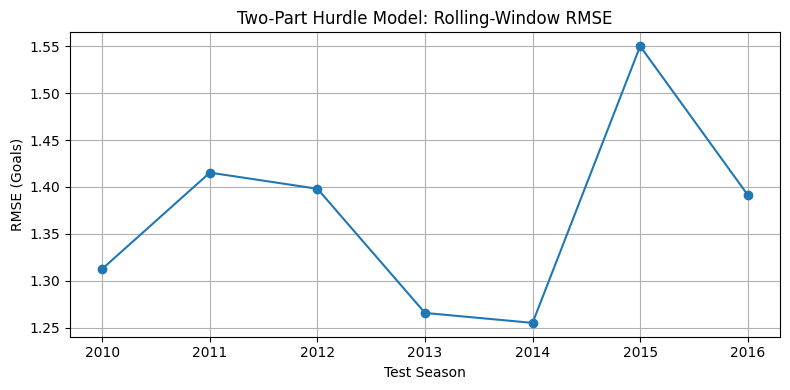

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

results = []
min_train = 3

for i in range(min_train, len(seasons)):
    train_seasons = seasons[:i]
    test_season   = seasons[i]

    train_df = df[df['season'].isin(train_seasons)]
    test_df  = df[df['season']==test_season]

    X_tr = train_df[features]
    y_tr = train_df['total_goals']
    X_te = test_df[features]
    y_te = test_df['total_goals']

    # Binary target: did score > 0 this season?
    y_cls_tr = (y_tr > 0).astype(int)
    y_cls_te = (y_te > 0).astype(int)

    # ---  Fit classifier ---
    clf = lgb.LGBMClassifier(
        learning_rate=0.05,
        verbose=-1,
        **{k:v for k,v in best_params.items() if k not in ['learning_rate', 'random_state']},
    )
    clf.fit(
        X_tr, y_cls_tr,
        eval_set=[(X_te, y_cls_te)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=20)]
    )
    p_any = clf.predict_proba(X_te)[:,1]  # P(score>0)

    # ---  Fit Poisson/Tweedie regressor on positives only ---
    pos_mask_tr = y_cls_tr==1
    pos_mask_te = y_cls_te==1

    reg = lgb.LGBMRegressor(
        random_state=42,
        verbose=-1,
        **{k:v for k,v in best_params.items() if k not in ['learning_rate', 'random_state', 'objective']},
    )
    reg.fit(
        X_tr[pos_mask_tr], y_tr[pos_mask_tr],
        eval_set=[(X_te[pos_mask_te], y_te[pos_mask_te])],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    m_count = reg.predict(X_te)           # E[goals] (includes zeros)

    # --- Combine & score ---
    y_hat = p_any * m_count
    rmse  = np.sqrt(mean_squared_error(y_te, y_hat))

    results.append({
        'train_upto': train_seasons[-1],
        'test_season': test_season,
        'rmse': rmse
    })

# ---  Summarize & plot ---
backtest_df = pd.DataFrame(results)
print("\nHurdle‐Model Rolling‐Window RMSE:")
print(backtest_df.to_string(index=False))
print(f"\nAverage RMSE: {backtest_df['rmse'].mean():.3f}")

plt.figure(figsize=(8,4))
plt.plot(backtest_df['test_season'], backtest_df['rmse'], marker='o')
plt.title("Two-Part Hurdle Model: Rolling-Window RMSE")
plt.xlabel("Test Season")
plt.ylabel("RMSE (Goals)")
plt.grid(True)
plt.tight_layout()
plt.show()

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[192]	valid_0's auc: 0.918452	valid_0's poisson: 0.343015
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's l2: 6.04557
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.913078	valid_0's poisson: 0.385005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's l2: 5.30607
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.916574	valid_0's poisson: 0.38419
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 4.90963
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[446]	valid_0's auc: 0.930019	valid_0's poisson: 0.345693
Training until 

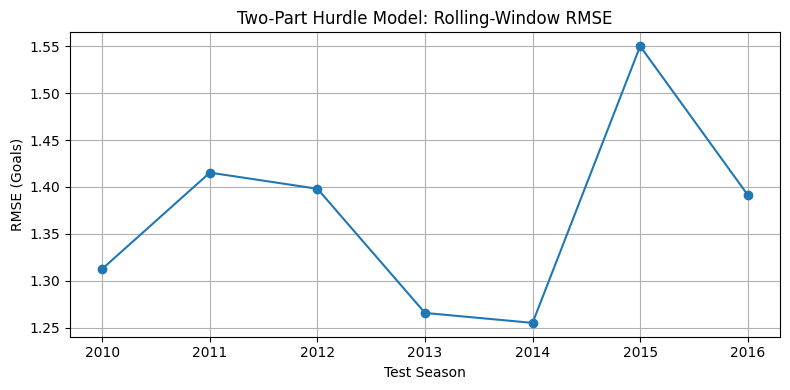

In [ ]:
from sklearn.metrics import precision_score, recall_score
import numpy as np


y_true_dict = {}
y_pred_label_dict = {}

results = []
min_train = 3

for i in range(min_train, len(seasons)):
    train_seasons = seasons[:i]
    test_season   = seasons[i]

    train_df = df[df['season'].isin(train_seasons)]
    test_df  = df[df['season']==test_season]

    X_tr = train_df[features]
    y_tr = train_df['total_goals']
    X_te = test_df[features]
    y_te = test_df['total_goals']

    # Binary target: did score > 0 this season?
    y_cls_tr = (y_tr > 0).astype(int)
    y_cls_te = (y_te > 0).astype(int)

    # ---  Fit classifier ---
    clf = lgb.LGBMClassifier(
        learning_rate=0.05,
        verbose=-1,
        **{k:v for k,v in best_params.items() if k not in ['learning_rate', 'random_state']},
    )
    clf.fit(
        X_tr, y_cls_tr,
        eval_set=[(X_te, y_cls_te)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=20)]
    )
    p_any = clf.predict_proba(X_te)[:,1]  # P(score>0)
    y_pred_labels = clf.predict(X_te) # Predicted labels for classification

    # Store true and predicted labels for the current season
    y_true_dict[test_season] = y_cls_te
    y_pred_label_dict[test_season] = y_pred_labels


    # ---  Fit Poisson/Tweedie regressor on positives only ---
    pos_mask_tr = y_cls_tr==1
    pos_mask_te = y_cls_te==1

    reg = lgb.LGBMRegressor(
        random_state=42,
        verbose=-1,
        **{k:v for k,v in best_params.items() if k not in ['learning_rate', 'random_state', 'objective']},
    )
    reg.fit(
        X_tr[pos_mask_tr], y_tr[pos_mask_tr],
        eval_set=[(X_te[pos_mask_te], y_te[pos_mask_te])],
        eval_metric='l2',
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    m_count = reg.predict(X_te)           # E[goals] (includes zeros)

    # ---  Combine & score ---
    y_hat = p_any * m_count
    rmse  = np.sqrt(mean_squared_error(y_te, y_hat))

    results.append({
        'train_upto': train_seasons[-1],
        'test_season': test_season,
        'rmse': rmse
    })

# ---  Summarize & plot RMSE ---
backtest_df = pd.DataFrame(results)
print("\nHurdle‐Model Rolling‐Window RMSE:")
print(backtest_df.to_string(index=False))
print(f"\nAverage RMSE: {backtest_df['rmse'].mean():.3f}")

plt.figure(figsize=(8,4))
plt.plot(backtest_df['test_season'], backtest_df['rmse'], marker='o')
plt.title("Two-Part Hurdle Model: Rolling-Window RMSE")
plt.xlabel("Test Season")
plt.ylabel("RMSE (Goals)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate per-season precision and recall
precisions, recalls = [], []
for s in seasons:
    if s in y_true_dict and s in y_pred_label_dict: # Check if season data exists
        y_true = y_true_dict[s]
        y_pred = y_pred_label_dict[s]
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append   (recall_score   (y_true, y_pred))

print("Per-season Precision:", np.round(precisions, 3))
print("Per-season Recall:   ", np.round(recalls,    3))
print("Average Precision:   ", np.mean(precisions))
print("Average Recall:      ", np.mean(recalls))

Per-season Precision: [0.724]
Per-season Recall:    [0.53]
Average Precision:    0.7239709443099274
Average Recall:       0.5296722763507529
